In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239


## Setup environment

In [2]:
!pip install monai
!pip install monai-generative
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [3]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-03-22 16:49:59.655421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 16:49:59.655616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 16:49:59.767614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 16:50:02.716125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
!pip3 install torchvision

## Setup imports

In [5]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

#from monai.metrics.fid import FIDMetric

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpcjhnrcqa


## Set deterministic training for reproducibility

In [7]:
set_determinism(42)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [8]:
#train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
#train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [9]:
#train_transforms = transforms.Compose(
#    [
#        transforms.LoadImaged(keys=["image"]),
#        transforms.EnsureChannelFirstd(keys=["image"]),
#        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
#        transforms.RandAffined(
#            keys=["image"],
#            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
#            translate_range=[(-1, 1), (-1, 1)],
#            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
#            spatial_size=[64, 64],
#            padding_mode="zeros",
#            prob=0.5,
#        ),
#    ]
#)
#train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
#train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

In [10]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:01, 59.9MB/s]                            

2024-03-22 16:50:29,170 - INFO - Downloaded: /tmp/tmpcjhnrcqa/MedNIST.tar.gz


2024-03-22 16:50:29,378 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-22 16:50:29,382 - INFO - Writing into directory: /tmp/tmpcjhnrcqa.


Loading dataset: 100%|██████████| 47164/47164 [00:35<00:00, 1314.49it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

2024-03-22 16:51:26,845 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-22 16:51:26,846 - INFO - File exists: /tmp/tmpcjhnrcqa/MedNIST.tar.gz, skipped downloading.
2024-03-22 16:51:26,850 - INFO - Non-empty folder exists in /tmp/tmpcjhnrcqa/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 972/972 [00:01<00:00, 694.94it/s]


### Visualisation of the training images

batch shape: torch.Size([64, 1, 64, 64])


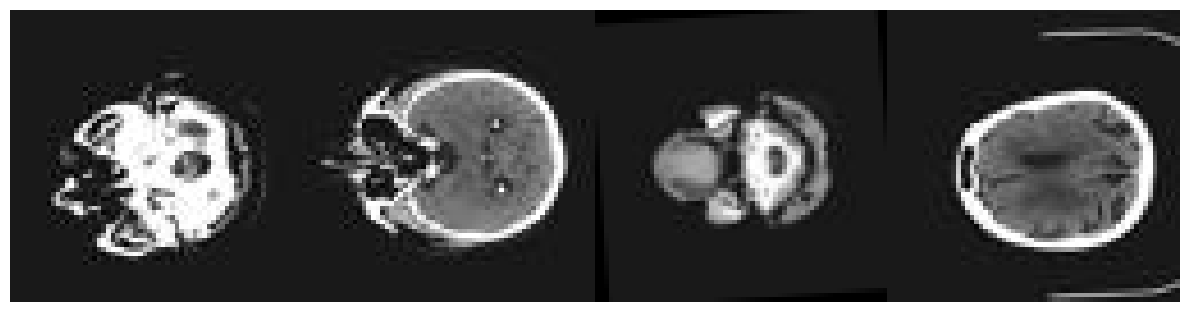

In [12]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [13]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training
Here, we are training our model for 10 epochs .

If you would like to skip the training and use a pre-trained model instead, set `use_pretrained=True`. This model was trained using the code in `tutorials/generative/distributed_training/ddpm_training_ddp.py`

100%|██████████| 1000/1000 [00:17<00:00, 58.73it/s]


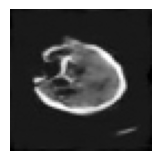

100%|██████████| 1000/1000 [00:16<00:00, 59.29it/s]


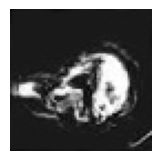

100%|██████████| 1000/1000 [00:16<00:00, 59.30it/s]


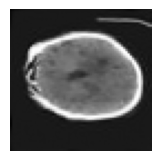

100%|██████████| 1000/1000 [00:17<00:00, 57.08it/s]


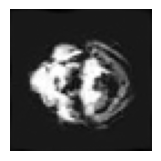

train completed, total time: 3859.8973212242126.


In [14]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 40
    val_interval = 10
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            for step, batch in enumerate(val_loader):
                images = batch["image"].to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        timesteps = torch.randint(
                            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                        ).long()
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

### Learning curves

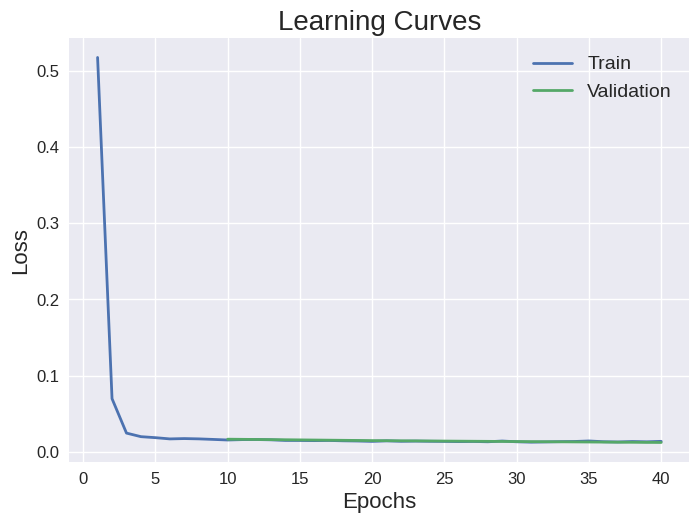

In [15]:
if not use_pretrained:
    plt.style.use("seaborn-v0_8")
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

### Plotting sampling process along DDPM's Markov chain

100%|██████████| 1000/1000 [00:16<00:00, 59.82it/s]


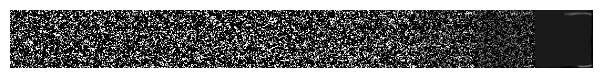

In [16]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

FID SCORE PLOTTING

In [ ]:
#image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

In [ ]:
import pickle

In [19]:
with open('diffusion_ddpm_model_HeadCT.pkl', 'wb') as f:
    pickle.dump(model, f)

In [20]:
device = torch.device("cuda")

with open('diffusion_ddpm_model_HeadCT.pkl', 'rb') as file:
  unet = pickle.load(file)
unet.to(device)


DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
    

In [21]:
from generative.metrics import FIDMetric, MMDMetric
from monai.metrics import compute_frechet_distance,compute_mmd

In [22]:
radnet = torch.hub.load("Warvito/radimagenet-models", model="radimagenet_resnet50", verbose=True)
radnet.to(device)
radnet.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/Warvito/radimagenet-models/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1VOWHgOq0rm7OkE_JxlWXhMAH4CvcXUHT
From (redirected): https://drive.google.com/uc?export=download&id=1VOWHgOq0rm7OkE_JxlWXhMAH4CvcXUHT&confirm=t&uuid=cd8cf2fb-3cc6-401

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm

In [23]:
def spatial_average(x: torch.Tensor, keepdim: bool = True) -> torch.Tensor:
    return x.mean([2, 3], keepdim=keepdim)


def get_features(image):
    # If input has just 1 channel, repeat channel to have 3 channels
    if image.shape[1]:
        image = image.repeat(1, 3, 1, 1)

    # Change order from 'RGB' to 'BGR'
    image = image[:, [2, 1, 0], ...]

    # Get model outputs
    with torch.no_grad():
        feature_image = radnet.forward(image)
        # flattens the image spatially
        feature_image = spatial_average(feature_image, keepdim=False)

    return feature_image

In [24]:
import scipy
def _sqrtm(input_data: torch.Tensor) -> torch.Tensor:
    """Compute the square root of a matrix."""
    scipy_res, _ = scipy.linalg.sqrtm(input_data.detach().cpu().numpy().astype(np.float_), disp=False)
    return torch.from_numpy(scipy_res)

def get_fid_score(y_pred: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Computes the FID score metric on a batch of feature vectors.

    Args:
        y_pred: feature vectors extracted from a pretrained network run on generated images.
        y: feature vectors extracted from a pretrained network run on images from the real data distribution.
    """
    y = y.double()
    y_pred = y_pred.double()
    if y.ndimension() > 2:
        raise ValueError("Inputs should have (number images, number of features) shape.")

    mu_y_pred = torch.mean(y_pred, dim=0)
    sigma_y_pred = _cov(y_pred, rowvar=False)
    mu_y = torch.mean(y, dim=0)
    sigma_y = _cov(y, rowvar=False)

    return compute_frechet_distance(mu_y_pred, sigma_y_pred, mu_y, sigma_y)

def _cov(input_data: torch.Tensor, rowvar: bool = True) -> torch.Tensor:
    """
    Estimate a covariance matrix of the variables.

    Args:
        input_data: A 1-D or 2-D array containing multiple variables and observations. Each row of `m` represents a variable,
            and each column a single observation of all those variables.
        rowvar: If rowvar is True (default), then each row represents a variable, with observations in the columns.
            Otherwise, the relationship is transposed: each column represents a variable, while the rows contain
            observations.
    """
    if input_data.dim() < 2:
        input_data = input_data.view(1, -1)

    if not rowvar and input_data.size(0) != 1:
        input_data = input_data.t()

    factor = 1.0 / (input_data.size(1) - 1)
    input_data = input_data - torch.mean(input_data, dim=1, keepdim=True)
    return factor * input_data.matmul(input_data.t()).squeeze()


def compute_frechet_distance(
    mu_x: torch.Tensor, sigma_x: torch.Tensor, mu_y: torch.Tensor, sigma_y: torch.Tensor, epsilon: float = 1e-6
) -> torch.Tensor:
    """The Frechet distance between multivariate normal distributions."""
    diff = mu_x - mu_y

    res=diff.dot(diff) + torch.trace(sigma_x) + torch.trace(sigma_y)

    return res

100%|██████████| 1000/1000 [08:53<00:00,  1.87it/s]


FID Score: 40.9622


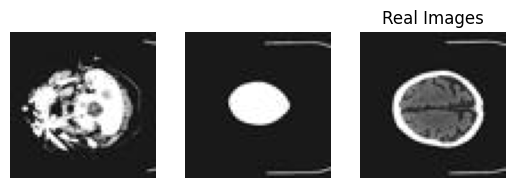

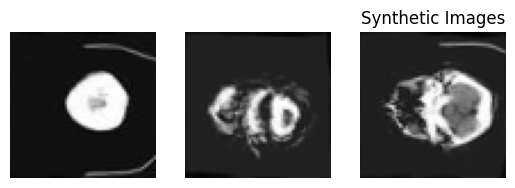

100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


FID Score: 39.4936


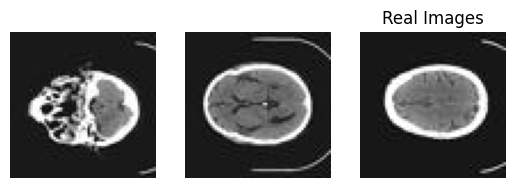

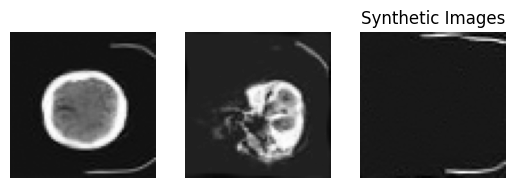

100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


FID Score: 45.5593


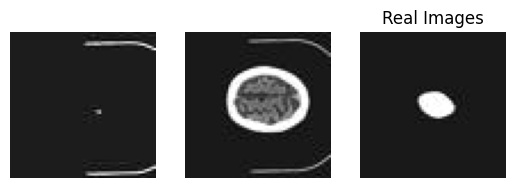

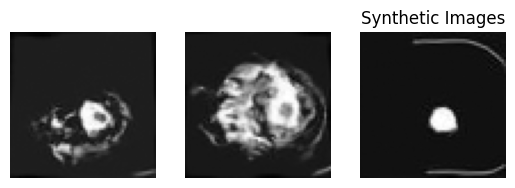

100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


FID Score: 37.6712


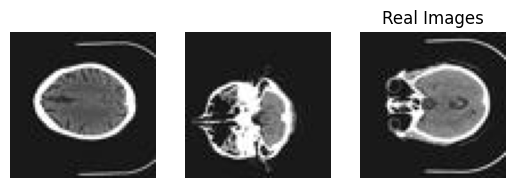

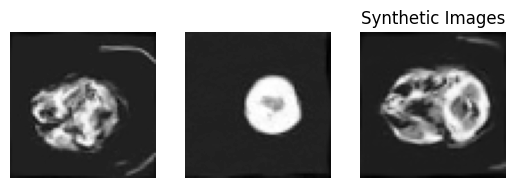

100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


FID Score: 38.6152


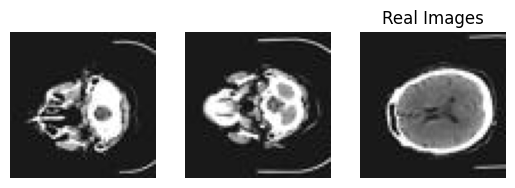

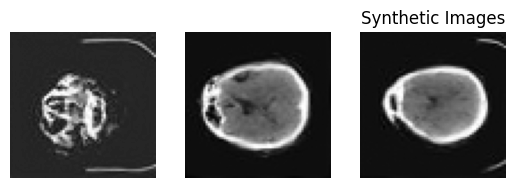

100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


FID Score: 40.0120


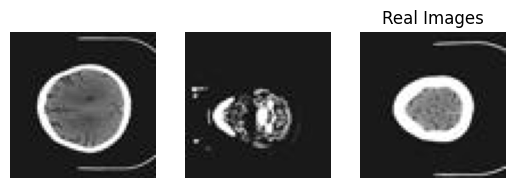

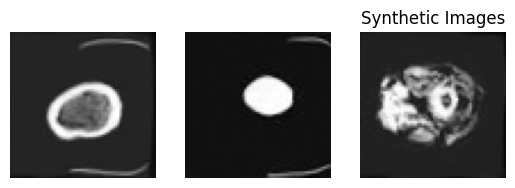

100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


FID Score: 43.8374


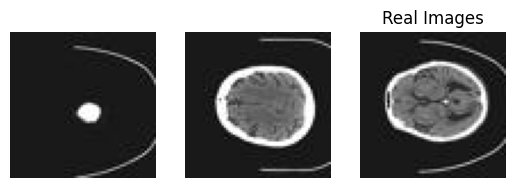

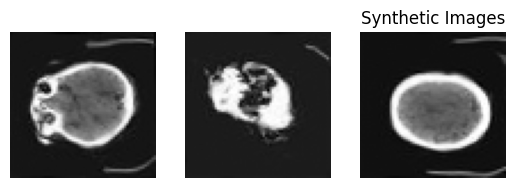

100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


FID Score: 41.1292


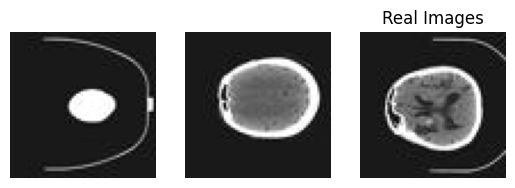

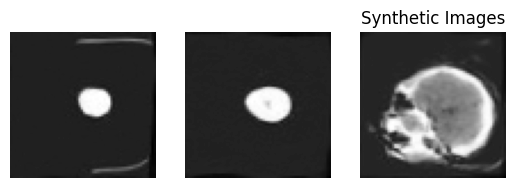

  3%|▎         | 31/1000 [00:16<08:34,  1.88it/s]

In [ ]:
synth_features = []
real_features = []

for step, x in enumerate(val_loader):
    # Get the real images
    real_images = x["image"].to(device)


    # Generate some synthetic images using the defined model
    n_synthetic_images = len(x["image"])
    noise = torch.randn((n_synthetic_images, 1, 64, 64))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=1000)

    with torch.no_grad():

        syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

        # Get the features for the real data
        real_eval_feats = get_features(real_images)
        # Get the features for the synthetic data
        synth_eval_feats = get_features(syn_images)
        try:
          fid_res = get_fid_score(real_eval_feats, synth_eval_feats)
          if fid_res<100 and fid_res>0:
            print(f"FID Score: {fid_res.item():.4f}")
            fig, ax = plt.subplots(nrows=1, ncols=3)
            for image_n in range(3):
              ax[image_n].imshow(real_images[image_n, 0, :, :].cpu(), cmap="gray")
              ax[image_n].axis("off")
            plt.title("Real Images")
            plt.show()
            fig, ax = plt.subplots(nrows=1, ncols=3)
            for image_n in range(3):
              ax[image_n].imshow(syn_images[image_n, 0, :, :].cpu(), cmap="gray")
              ax[image_n].axis("off")
            plt.title("Synthetic Images")
            plt.show()
          else:
            continue
        except ValueError as e:
          print("Error computing FID:", e)

In [ ]:
mmd_scores = []

mmd = MMDMetric()

for step, x in list(enumerate(val_loader)):
    image = x["image"].to(device)

    with torch.no_grad():
        image_recon = autoencoderkl.reconstruct(image)

    mmd_scores.append(mmd(image, image_recon))

mmd_scores = torch.stack(mmd_scores)
print(f"MMD score: {mmd_scores.mean().item():.8f} +- {mmd_scores.std().item():.8f}")

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)